In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from grangercausality_test import GrangerCausalityTest
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.tsatools import lagmat2ds
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy import stats
from utils.utils import *
from statsmodels.tsa.vector_ar.var_model import VAR
path = '../stats_files/'

In [2]:
tb = os.listdir('../stats_files')
tb

['causality_time_statistics.csv',
 'causation_in_out_data.csv',
 'correlation_time_statistics.csv',
 'corr_networkx_graph.pickle',
 'corr_table.csv',
 'directed_networkx_graph.pickle',
 'failure_data.csv',
 'full_causality_table.csv',
 'full_causality_table_labeled.csv',
 'stationary_percent.csv',
 'top_100_variables.csv']

In [3]:
df = pd.read_csv('../stats_files/full_causality_table.csv')
df.set_index(df.columns[0],inplace=True)

In [4]:
df.head()

,MODE_Mode,GPS_GCrs,GPS_Alt,GPS_NSats,GPS_Spd,GPS_Lat,GPS_Status,GPS_HDop,GPS_Lng,DU32_Id,...,RAD_RxErrors,RAD_RemNoise,RAD_Fixed,RAD_RSSI,RAD_Noise,RAD_TxBuf,RAD_RemRSSI,IMU_TimeMS,MAG_MagZ,MAG_OfsX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
MODE_Mode,NaN,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,NaN,...,NaN,0.0,NaN,0.0,1.0,0.0,NaN,NaN,1.0,NaN
GPS_GCrs,0.0,NaN,0.0,0.0,0.0,1.0,1.0,0.0,2.0,NaN,...,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0
GPS_Alt,1.0,0.0,NaN,1.0,1.0,1.0,2.0,1.0,2.0,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,NaN
GPS_NSats,1.0,0.0,1.0,NaN,1.0,1.0,0.0,2.0,1.0,NaN,...,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0
GPS_Spd,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,...,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,2.0,NaN


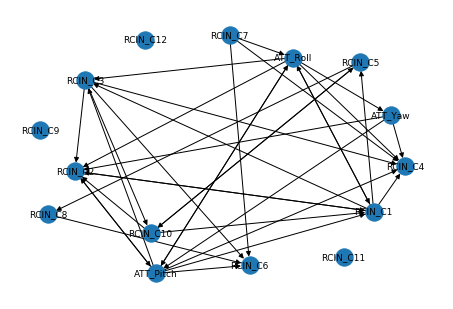

In [11]:
DG = nx.DiGraph()
DG.add_nodes_from(df.columns)
all_nodes = []
l_visited = []
for idx in df.index:  
    ltuples = [(idx,cl) for cl in df.columns[df.loc[idx] == 1] if idx != cl and (idx,cl) not in all_nodes]
    ltuples_bi = [(idx,cl) for cl in df.columns[df.loc[idx] == 2 ] if cl != idx and (idx,cl) not in all_nodes]
    l_visited = [(cl,idx) for cl in df.columns[df.loc[idx] == 1] if idx != cl]
    all_nodes += l_visited
    DG.add_edges_from(ltuples)
    DG.add_edges_from(ltuples_bi)
    ltuples = []
    ltuples_bi =[]

#save_as_pickle(DG,'../stats_files','directed_networkx_graph.pickle') #saving the graph to be used later for analysis
#create tuples
#pos = nx.spring_layout(DG,k=1,iterations=50)
# plt.figure(figsize=(20,10))
# nx.draw(DG,with_labels=True,font_size=9,pos=pos)
# plt.draw()
# plt.show()

nds= []
for n in DG.nodes:
    if 'RCIN' in n:
        nds.append(n)
H = DG.subgraph(nds+['ATT_Yaw','ATT_Pitch','ATT_Roll'])
pos = nx.spring_layout(H,k=4,iterations=40)
nx.draw(H,with_labels=True,font_size=9,pos=pos)
plt.draw()
plt.show()

In [6]:
print(nds+['ATT_YAW'])

['RCIN_C1', 'RCIN_C5', 'RCIN_C11', 'RCIN_C7', 'RCIN_C10', 'RCIN_C3', 'RCIN_C12', 'RCIN_C8', 'RCIN_C9', 'RCIN_C6', 'RCIN_C4', 'RCIN_C2', 'ATT_YAW']


In [ ]:
all_nodes

In [ ]:
nds = dg.neighbors('CTUN_ThrOut')
# for n in dg.nodes:
#     if 'Alt' in n:
#         nds.append(n)
# print(nds)
nds = [cl for cl in df.columns[df.loc['CTUN_ThrOut'] == 1]]
dg = load_pickle('../stats_files','directed_networkx_graph.pickle')
pos = nx.spring_layout(dg,k=2,iterations=10)
plt.figure(figsize=(20,10))
nx.draw(dg,with_labels=True,font_size=9,pos=pos)
plt.draw()
plt.show()

In [ ]:
df.loc['RCIN_C1','CTUN_ThrOut']

In [ ]:
ltuples

In [ ]:
stat_in_out = []
for c in df.columns:
    outgoing_count = len(DG.out_edges(c))
    incoming_count = len(DG.in_edges(c))
    stat_in_out.append((c,incoming_count,outgoing_count))
df_inout = pd.DataFrame(stat_in_out,columns=['signal','incoming','outgoing'])

In [ ]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='signal',y='incoming',data=df_inout.sort_values('incoming',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('incoming',ascending=False).signal,rotation=90)
plt.ylabel('Incoming Causes') 
plt.show()
figure = g.get_figure()  
figure.savefig('../report/incoming_causation.png', dpi=500)

In [ ]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='signal',y='outgoing',data=df_inout.sort_values('outgoing',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('outgoing',ascending=False).signal,rotation=90)
plt.ylabel('Outgoing Causes')
plt.show()
figure = g.get_figure()  
figure.savefig('../report/outgoing_causation.png', dpi=500)

In [ ]:
df_inout.to_csv('../stats_files/causation_in_out_data.csv')

# Time Analysis

In [ ]:
tm = pd.read_csv(path+'causality_time_statistics.csv')
tm = tm.sort_values('size MB',ascending=True).reset_index().drop(tm.columns[:2],axis=1)

In [ ]:
tm.loc[len(tm)] = ('58c3e69a03d9b00f21696b11.log', 50.516817, 1349.1730382442474)

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(y='duration s',x='size MB',data=tm)
plt.ylabel('Seconds')
plt.xlabel('MB')
plt.title('Top 100 Causality Time Statistic')
plt.show()